# Complete image processing
This is the notebook in which I would load a stack of real images and then test an entire processing pipeline

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='inferno')

In [2]:
import sys
# sys.path.append("../data/denoising_experiments/")
sys.path.append("../common/")
import isxd_reader
import denoising

In [3]:
import scipy.signal

In [4]:
movie_path = "../data/denoising_experiments/2022-10-14-07-48-47_video.isxd"
full_stack = isxd_reader.img_stack(movie_path)

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

The commented out code above was me loading from the original `isxd` recording. The problem with this was that image features moved around non-rigidly, so my methods involving temporal means caused blurring. To get rid of this I applied NoRMCorre ([Pnevmatikakis, 2017](https://doi.org/10.1016/j.jneumeth.2017.07.031)) to produce a new `tif` movie. This new motion-corrected movie should be loaded instead of the raw `isxd` as above.

In [6]:
# import imageio
# full_stack = imageio.volread("../data/denoising_experiments/2022-10-14-07-48-47_video_normcorre.tif")

In [7]:
full_stack.shape

(80, 400, 640)

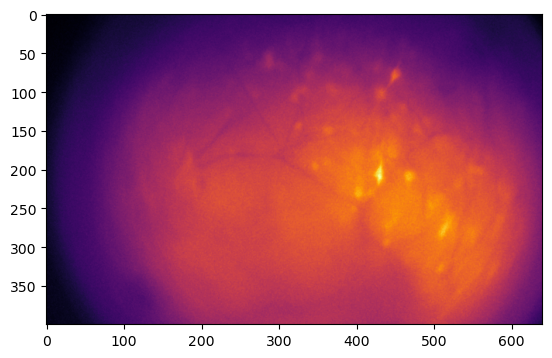

In [8]:
plt.imshow(full_stack[30])

In [9]:
full_stack[30].shape

(400, 640)

### Making the Multiwienernet
To initialize the multiwienernet, we need starting PSFs and Ks. These are immediately replaced with the learned PSFs and Ks loaded from disk, but I wonder whether the size of the PSFs with which this is initialized is important in terms of the PSF dimensions. If it is, that means that everywhere we load it, we must input the path to those PSFs. Alternatively, we could just write a function that loads the same large PSFs behind the scenes that just have to be present on the user's machine.

Just verified that the initial size of the PSFs _is_ important.

Perhaps rather than actually loading some number of PSFs, I will just create an appropriately-sized empty `ndarray` that is immediately replaced by whatever is loaded from disk

The size of `psfs` that is fed into the initialized multiwienernet is `(800, 1280, 21)` regardless of the size of the PSF (64x64 or 32x32) taken from Zemax.

In [10]:
import preset_nn

model = preset_nn.instant_multiwienernet()
# model = preset_nn.instant_multiwienernet(pooling='averageblur')

# model.load_weights("saved_models/multiwiener_nV3_probe_noisy2/model_weights")
# model.load_weights("saved_models/multiwiener_nV3_probe_noisy4/model_weights")
# model.load_weights("saved_models/multiwiener_nV3_probe_noisy5/model_weights")
# model.load_weights("saved_models/multiwiener_nV3_probe_equivariant/model_weights")
# model.load_weights("saved_models/multiwiener/model_weights")
# model.load_weights("saved_models/multiwiener_nV3_probe_noisy3/model_weights")
# model.load_weights("saved_models/multiwiener_nV3_probe/model_weights")
# weights_path = "saved_models/multiwiener_nV3_probe_noisy4/model_weights"
weights_path = "saved_models/multiwiener_nV3_probe_noisy5/model_weights"
# weights_path = "saved_models/multiwiener_nV3_probe_noisy5_new_way/model_weights"
# weights_path = "saved_models/multiwiener_nV3_probe_equivariant/model_weights"
# weights_path = "saved_models/multiwiener_nV3_probe/model_weights"
# weights_path = "saved_models/multiwiener_nV3_probe_noisy5_new_way2/model_weights"
model.load_weights(weights_path)

2023-03-29 11:51:30.893200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 11:51:34.690390: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-29 11:51:39.198334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dshteinbok/anaconda3/envs/tf/lib/python3.9/site-packages/cv2/../../../../lib:
2023-03-29 11:51:39.198939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libn

In [11]:
model.layers

In [12]:
import cv2
cv2.resize?

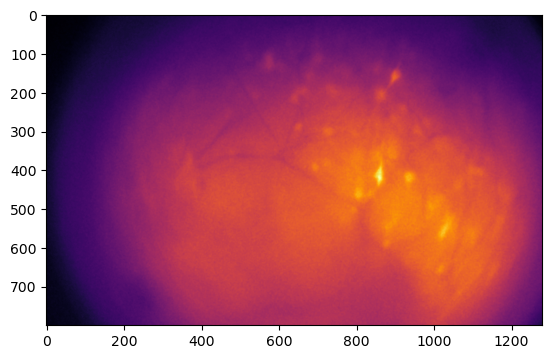

In [13]:
plt.imshow(cv2.resize(full_stack[30], (1280, 800)))

2023-03-29 11:51:52.611780: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2023-03-29 11:51:53.731247: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


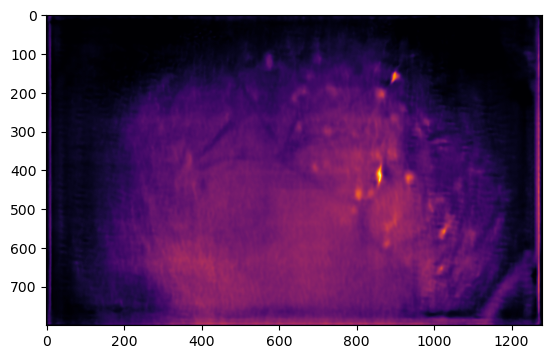

In [14]:
upsampled_img = np.empty((800,1280))
cv2.resize(full_stack[30], (1280, 800), upsampled_img)
plt.imshow((model(upsampled_img.reshape((1,800,1280,1)))[0,:,:]))

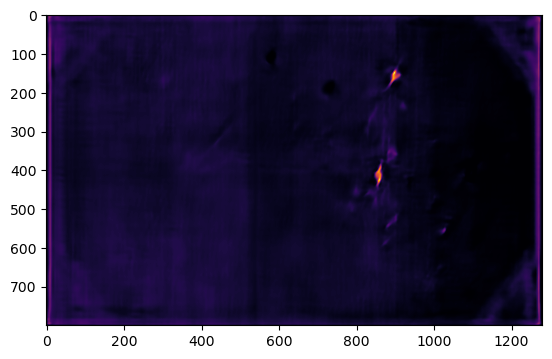

In [15]:
denoised_img = denoising.full_denoising(full_stack, 30, np.mean(full_stack, axis=0), h=8)

plt.imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))

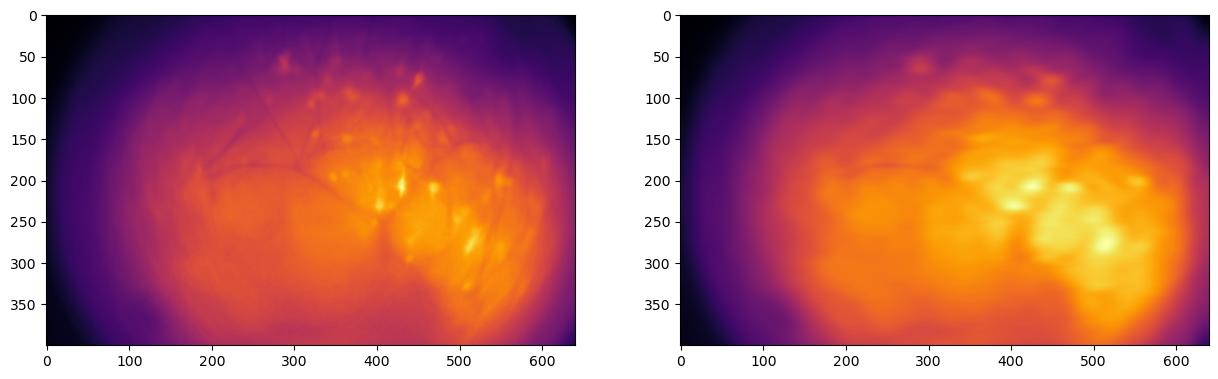

In [16]:
import scipy.fftpack
background = np.mean(full_stack, axis=0)
fig, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(background)
background_dct = scipy.fftpack.dct(background)
background_dct[5:, 32:] = 0
background_lowpass = scipy.fftpack.idct(background_dct)
background_lowpass -= np.min(background_lowpass)
background_lowpass *= (np.max(background) - np.min(background))/np.max(background_lowpass)
background_lowpass += np.min(background)
axs[1].imshow(background_lowpass)

In [17]:
np.max(background_lowpass)

1478.775

In [18]:
np.max(background)

1478.775

In [19]:
np.max(full_stack)

1683.0

In [20]:
# fig, axs = plt.subplots(3, 1, figsize=(15,15))
# ind = 30

# # background = np.mean(full_stack, axis=0)
# # denoised_img = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=8, num_images=5)
# denoised_img = denoising.full_denoising(full_stack, ind, background, h)

Text(0.5, 1.0, '30th frame, df/f denoised after multiwienernet')

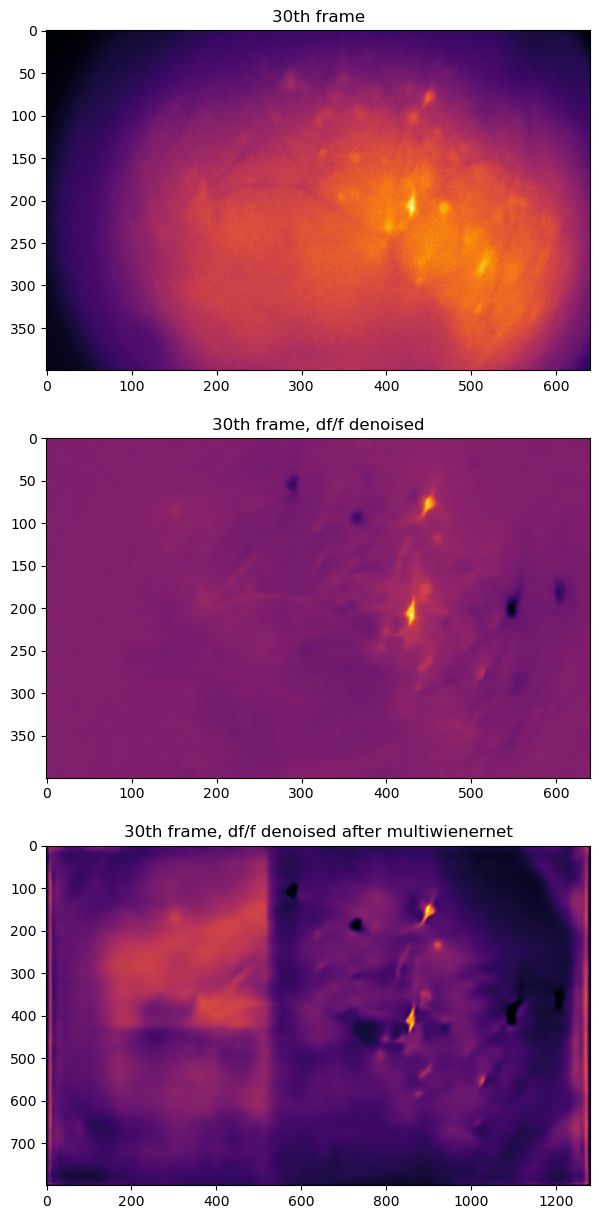

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))
ind = 30

# background = np.mean(full_stack, axis=0)
# denoised_img = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=8, num_images=5)
denoised_img = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=25, num_images=5, denoising_method="BM3D")
# denoised_img = denoising.full_denoising(full_stack, ind, background_lowpass, h=8, num_images=5)
# denoised_img = np.mean(denoising.get_similar(full_stack, ind, 5), axis=0)
# denoised_img = denoising.dff(np.mean(denoising.get_similar(full_stack, ind, 5), axis=0), np.mean(full_stack, axis=0))
# denoised_img = denoising.dff(full_stack[ind], np.mean(full_stack, axis=0))

# added median filtering
# denoised_img = scipy.signal.medfilt2d(denoised_img, kernel_size=5)

axs[0].imshow(full_stack[ind])
axs[0].set_title(str(ind) + "th frame")
axs[1].imshow(denoised_img)
axs[1].set_title(str(ind) + "th frame, df/f denoised")
axs[2].imshow((model(cv2.resize(denoising.rescale_to_one(denoised_img), (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
axs[2].set_title(str(ind) + "th frame, df/f denoised after multiwienernet")

In [22]:
noise = denoising.dff(full_stack[ind], np.mean(full_stack, axis=0)) - denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=8, num_images=5)

In [23]:
np.max(denoising.dff(full_stack[ind], np.mean(full_stack, axis=0)))

244.6500000000001

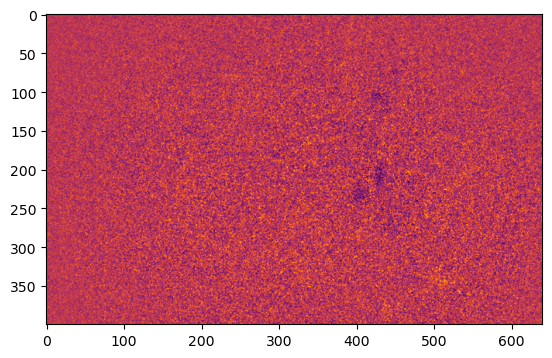

In [24]:
plt.imshow(noise)

In [25]:
np.var(noise)

126.37121932367678

In [26]:
np.max(denoising.dff(full_stack[ind], np.mean(full_stack, axis=0)))

244.6500000000001

In [27]:
np.sqrt(np.var(noise))*np.sqrt(5)

25.136747932427216

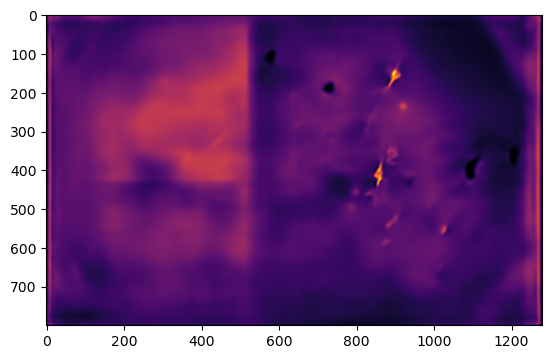

In [28]:
ind=30
denoised_img = denoising.rescale_to_one(
    denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=8, num_images=5))

# plt.figure(figsize=(800,1280), dpi=20)
plt.imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))

In [29]:
np.max(model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:])

1.0724018

In [30]:
np.max(denoised_img)

1.0

In [31]:
a = np.arange(10)
a[5:6]

array([5])

In [32]:
movie_path = "../data/denoising_experiments/2022-10-14-07-48-47_video.isxd"
raw_stack = isxd_reader.img_stack(movie_path)

On iteration 0, MSE is: 258.58061718749997
On iteration 1, MSE is: 268.67235546874997
On iteration 2, MSE is: 266.964015625
On iteration 3, MSE is: 269.8365703125


Text(0.5, 1.0, '50th image, no motion-correction')

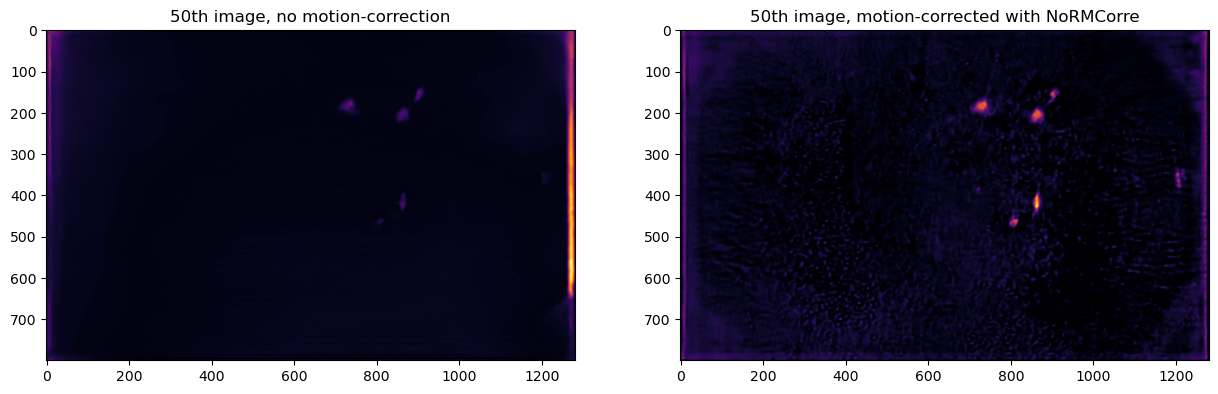

In [33]:
# compare the processed image from full_stack (which has been motion-corrected) with that from the raw
ind = 50
fig, axs = plt.subplots(1,2,figsize=(15,15))
denoised_normcorre = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=4, num_images=5, verbose=True)
denoised_raw = denoising.rescale_to_one(denoising.full_denoising(raw_stack, ind, np.mean(raw_stack, axis=0), h=4, num_images=5))
axs[1].imshow(model(cv2.resize(denoised_normcorre, (1280, 800)).reshape((1,800,1280,1)))[0,:,:])
axs[1].set_title(str(ind) + "th image, motion-corrected with NoRMCorre")
axs[0].imshow(model(cv2.resize(denoised_raw, (1280, 800)).reshape((1,800,1280,1)))[0,:,:])
axs[0].set_title(str(ind) + "th image, no motion-correction")

In [34]:
# noise = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), num_images=5)-denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), num_images=1)
noise = denoising.full_denoising(raw_stack, ind, np.mean(raw_stack, axis=0), num_images=5)-denoising.full_denoising(raw_stack, ind, np.mean(raw_stack, axis=0), num_images=1)

In [35]:
np.var(noise[150:350, 100:300])

13292.65122559

In [36]:
np.sqrt(1151)

33.926390907374746

In [37]:
noise.max()

255

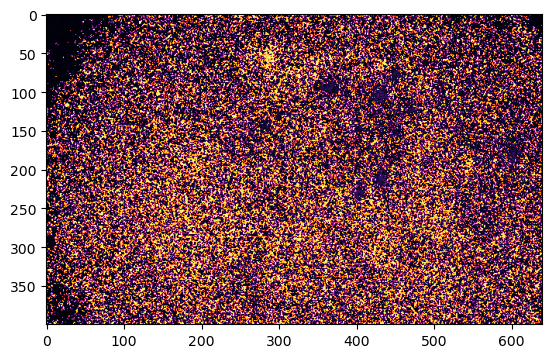

In [38]:
plt.imshow(noise)

In [39]:
denoised_img.max()

1.0

In [40]:
denoising.full_denoising(full_stack, ind+1, np.mean(full_stack, axis=0)).max()

255

In [41]:
full_stack.dtype

dtype('float64')

In [42]:
full_stack.max()

1683.0

## Testing Denoised, Background-In Image
Method: take raw image with background still in it, look at various methods of denoising to see effects of that

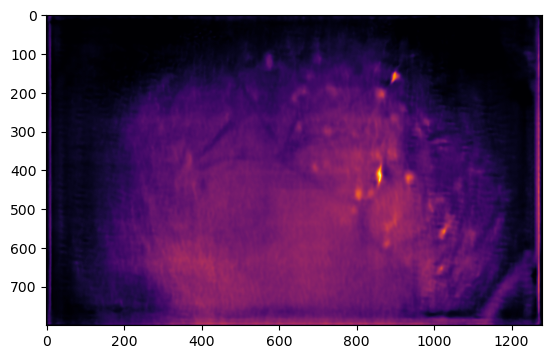

In [43]:
# "Control": just frame 30 of the movie, through NN directly
plt.imshow((model(cv2.resize(full_stack[30], (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))

Text(0.5, 1.0, 'Denoised, deconvolved')

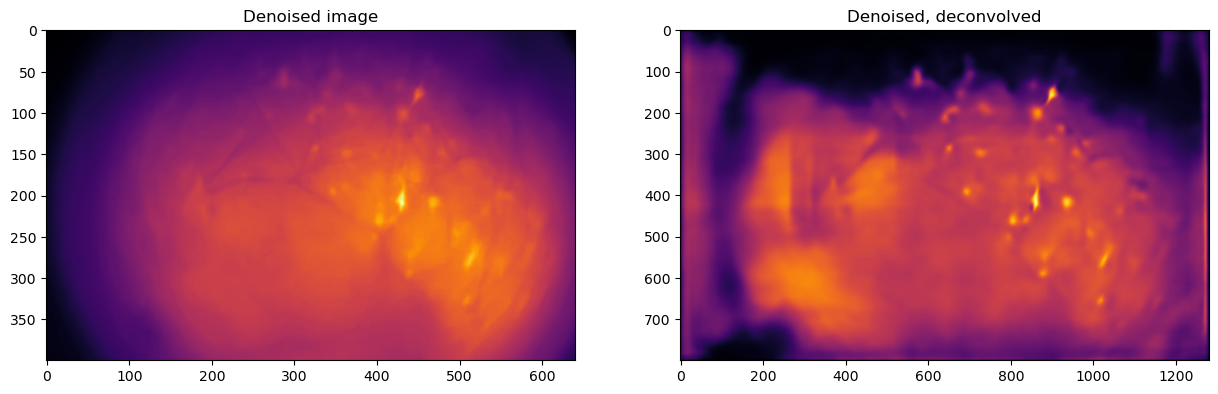

In [44]:
# Denoised image, through TLM and NLM
# to skip background removal, just give an ndarray of zeros as the background

ind=30
# f30_denoised_wbg =  denoising.full_denoising(full_stack, ind, np.zeros((400,640)), num_images=1, h=4)
# f30_denoised_wbg =  denoising.full_denoising(full_stack, ind, np.zeros((400,640)), num_images=5, h=4)
f30_denoised_wbg =  denoising.rescale_to_one(denoising.full_denoising(full_stack, ind, np.zeros((400,640)), num_images=1, h=5, denoising_method="BM3D"))
# f30_denoised_wbg = np.mean(denoising.get_similar(full_stack, ind, 5), axis=0)
# f30_denoised_wbg = full_stack[ind]
fig, axs = plt.subplots(1,2,figsize=(15,15))
# axs[0].imshow(full_stack[30])
# axs[0].set_title("30th image")

axs[0].imshow(f30_denoised_wbg)
axs[0].set_title("Denoised image")
# axs[0].set_title("30th image")

axs[1].imshow((model(cv2.resize(f30_denoised_wbg, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
axs[1].set_title("Denoised, deconvolved")
# axs[1].set_title("30th image, deconvolved")

In [45]:
list(range(0))

[]

In [46]:
for i in range(0):
    print(i)

## Testing the preservation of lines
It was noticed that axons of cells were disappearing after having been processed by the neural network. These axons were thin lines. It may make sense that a line could have been produced by the convolution of a point with a long and thin PSF (as at the edge of the FOV of the optical system). Consequently, it would make sense that the multiwienernet may try to deconvolve the thin line that is the axon as a dotted line. In fact, this is exactly what was observed when the denoising was turned down (Updates.pptx, slide 200, slide 222).

Thus, I want to see whether this is reproducible in directly plugging in images of lines

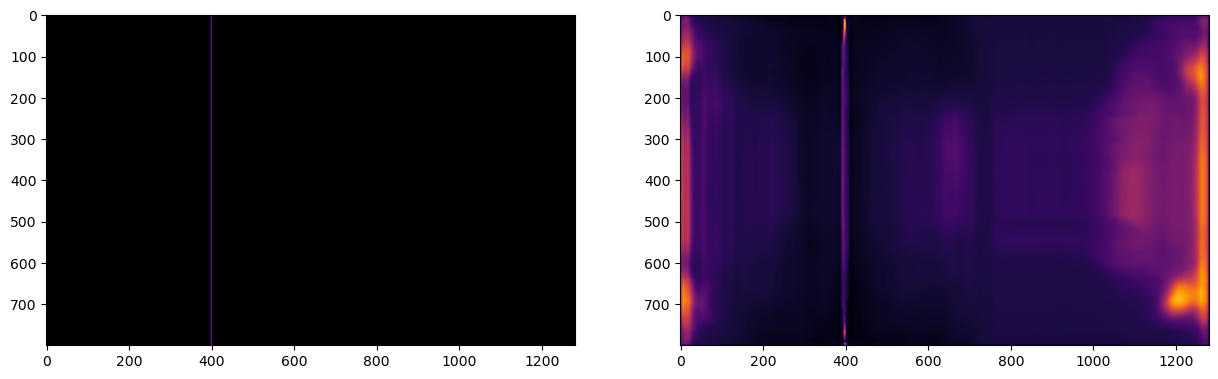

In [47]:
# test the ability of the neural network to just preserve a line through the input image

line_img = np.zeros((800,1280))

# this is the half-thickness less one; 
# this amount will be added to each side of the place we decide to draw the line
half_thickness_less_one = 0

#vertical line that goes all the way through the image from top to bottom in the center
img_center_vert = 400 
line_img[:, img_center_vert-half_thickness_less_one-1:img_center_vert+half_thickness_less_one] = 1

fig, axs = plt.subplots(1,2,figsize=(15,15))

axs[0].imshow(line_img)
axs[1].imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:]))

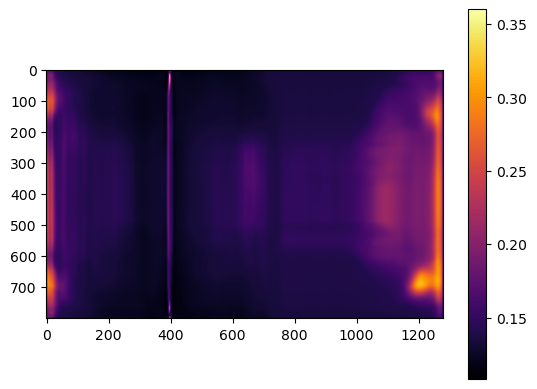

In [48]:
plt.imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:]))
plt.colorbar()

Above, it seems that a single line gets turned into a bunch of fringes, although those fringes are significantly darker than the original image (original line has a peak value of 1, this one has a peak value of 0.35).

It should also be noted that the neural network generally decreases the peak brightness of the image. For example, the denoised 30th frame of the movie has a maximum value of 253, which is expected (brightness is scaled to single byte before NLM denoising), but after the neural network the deconvolved image has a peak brightness of 143.

**TODO:** Figure this out; what values does the NN take in the first place? When and how do we scale during the full denoising?

For now, continuing with the analysis of line behavior.
**TODO:**
* What are the effects of the angle of the line?
* What are the effects of the thickness of the line?
* What are the effects of noise?

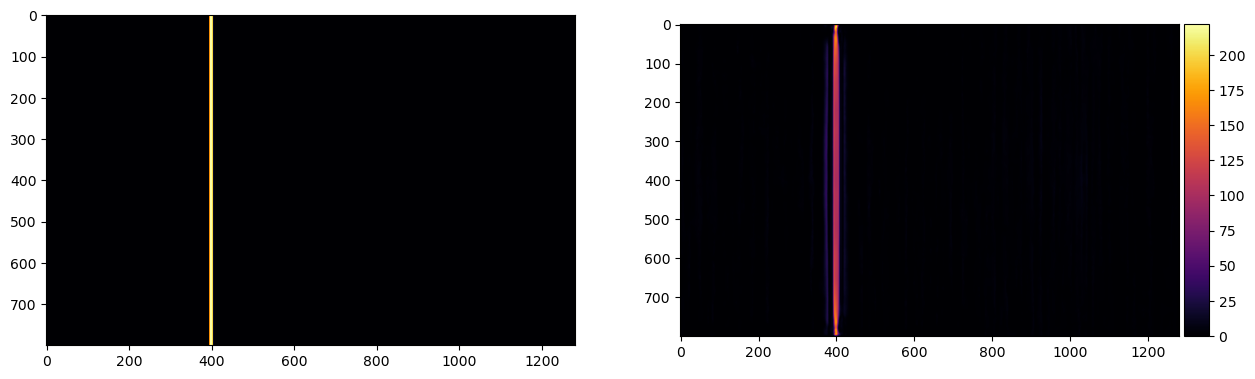

In [49]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Examining thickness
# copy-pasted from above, but with a different thickness value
line_img = np.zeros((800,1280))

# this is the half-thickness less one; 
# this amount will be added to each side of the place we decide to draw the line
# half_thickness_less_one = 5
# half_thickness_less_one = 2
# half_thickness_less_one = 3
half_thickness_less_one = 4
# half_thickness_less_one = 1

#vertical line that goes all the way through the image from top to bottom in the center
img_center_vert = 400 
line_img[:, img_center_vert-half_thickness_less_one-1:img_center_vert+half_thickness_less_one] = 255

fig, axs = plt.subplots(1,2,figsize=(15,15))

axs[0].imshow(line_img)
outimg = axs[1].imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:]))

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(outimg, cax=cax, orientation='vertical')

In [50]:
np.max(model(line_img.reshape((1,800,1280,1)))[0,:,:])

221.83409

In [51]:
np.max(line_img)

255.0

Observed that the thicker the original line, the less fringing behavior we have from the NN.
Also observed an interesting phenomenn in the last ~20px in the y-direction, where the NN produces a gap and two dots. This seems to happen regardless of the thickness of the line.

Now, let's examine the same thing with shorter lines

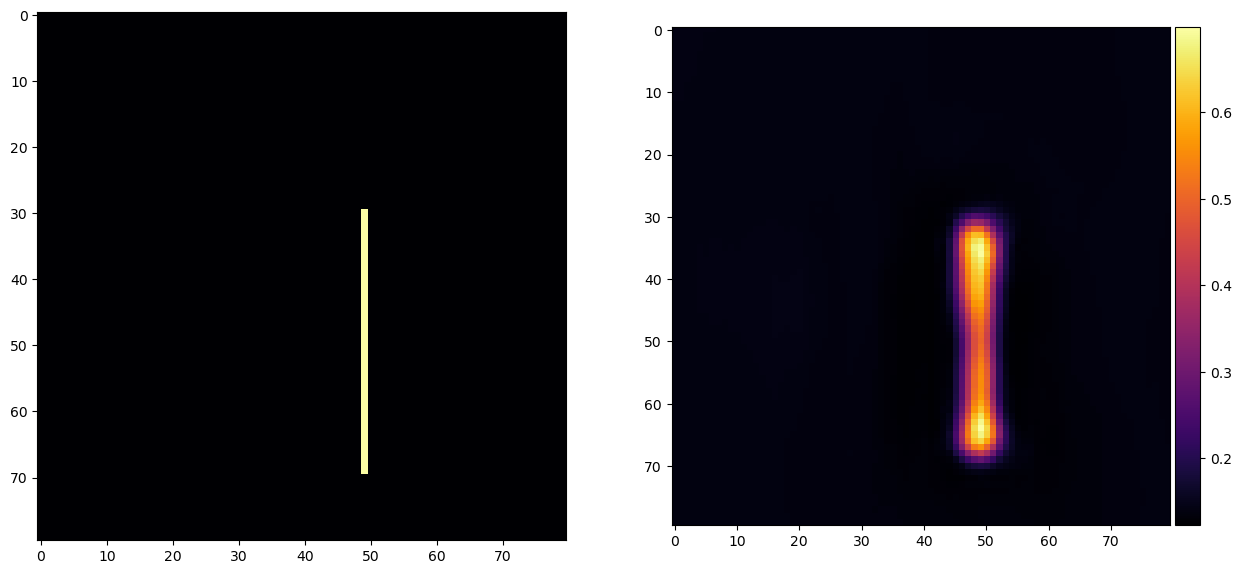

In [52]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Examining thickness
# copy-pasted from above, but with a different thickness value
line_img = np.zeros((800,1280))

# this is the half-thickness less one; 
# this amount will be added to each side of the place we decide to draw the line
# half_thickness_less_one = 5
# half_thickness_less_one = 2
# half_thickness_less_one = 3
# half_thickness_less_one = 4
# half_thickness_less_one = 1
half_thickness_less_one = 0
line_length = 40

#vertical line that goes all the way through the image from top to bottom in the center
img_center_vert = 400 
line_img[img_center_vert - line_length//2:img_center_vert + line_length//2,
         img_center_vert-half_thickness_less_one-1:img_center_vert+half_thickness_less_one] = 1

fig, axs = plt.subplots(1,2,figsize=(15,15))

axs[0].imshow(line_img[350:430, 350:430])
outimg = axs[1].imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:])[350:430, 350:430])

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(outimg, cax=cax, orientation='vertical')

The shifting upward and to the left becomes apparent, but no serious dotting.

Now, to investigate diagonal lines:

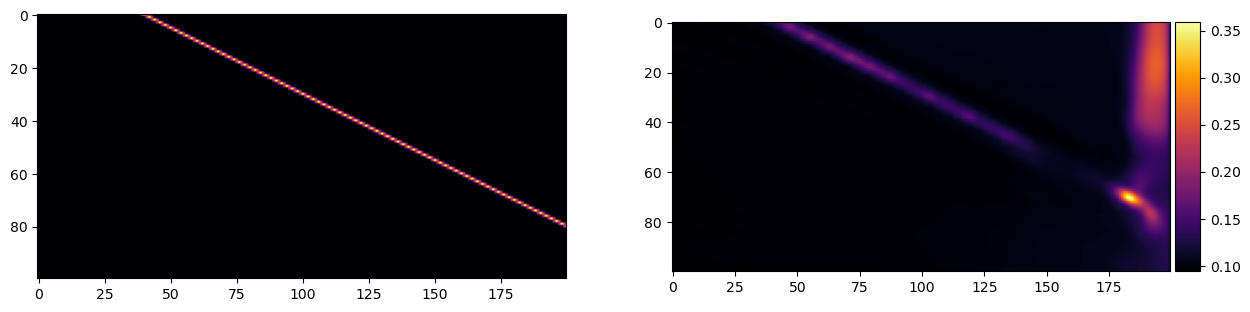

In [53]:
# to generate arbitrary diagonal lines, 
# we will need to generate three sets of points, then perform a linear interpolation over the entire image
# kind of tri-diagonal or something
slope = 0.5
x_length = 1280

# array of tuples containing coordinates of the non-zero values we care about
# we would simply shift these coordinates down by one and up by one to set the zero values
all_coords = []
all_vals = []
for i in range(x_length):
    all_coords.append((i, i*slope))
    all_vals.append(1)

# now we want to iterate through 1280 again for the lower zeros
# and then once more for the upper zeros
for i in range(x_length):
    all_coords.append((i, i*slope - 1))
    all_vals.append(0)
    
for i in range(x_length):
    all_coords.append((i, i*slope + 1))
    all_vals.append(0)

xq = np.arange(1280)
yq = np.arange(800)
[Xq, Yq] = np.meshgrid(xq, yq)

# we also need to surround the border with zeros, so the entire image is within the convex hull
# of our specified points
all_coords = all_coords + [(0, i) for i in range(800)] + [(1280, i) for i in range(800)] \
+ [(i, 0) for i in range(1280)] + [(i, 800) for i in range(1280)]

all_vals = all_vals + [0]*2*(800 + 1280)

line_img = scipy.interpolate.griddata(all_coords, all_vals, (Xq, Yq), method='linear')
line_img[np.isnan(line_img)] = 0
# plt.imshow(line_img)
# plt.colorbar()
fig, axs = plt.subplots(1,2,figsize=(15,15))

# axs[0].imshow(line_img)
axs[0].imshow(line_img[560:660, 1080:1280])
# outimg = axs[1].imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:]))
outimg = axs[1].imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:])[560:660, 1080:1280])

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(outimg, cax=cax, orientation='vertical')

### Addition of noise to line
Now, we want to see how the deconvolution of the line image will fare if AWGN is introduced to the vertical line.
This is pertinent because I expect it to exacerbate the dottiness of the line produced.

An important consideration is the standard deviation of the noise. I will start with the same level of AWGN I calculated for the actual observed $\Delta F/F$ images, but scaled to the (0,1) range. That is, $\sigma = 4.2/256 \approx 0.016$

**UPDATE:** I tried $\sigma=0.016$ and saw no result. I increased the standard deviation 10-fold from that point to get $\sigma=0.16$ which actually had an observable effect. This is what I ran below.

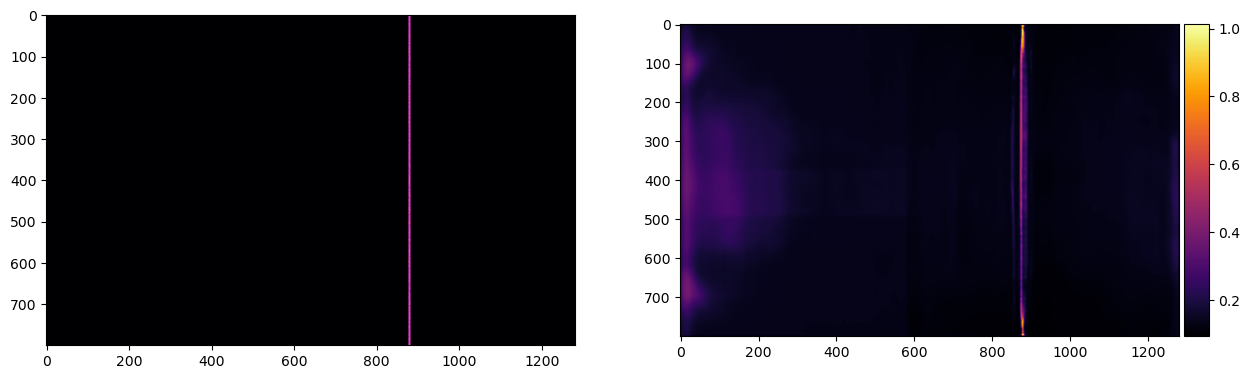

In [54]:
line_img = np.zeros((800,1280))

# this is the half-thickness less one; 
# this amount will be added to each side of the place we decide to draw the line
# half_thickness_less_one = 5
half_thickness_less_one = 2
# half_thickness_less_one = 3
# half_thickness_less_one = 4
# half_thickness_less_one = 1
# half_thickness_less_one = 0

#vertical line that goes all the way through the image from top to bottom in the center
img_center_vert = -400 
line_img[:, img_center_vert-half_thickness_less_one-1:img_center_vert+half_thickness_less_one] \
= np.random.normal(1, 0.16, size=(800, half_thickness_less_one*2 + 1))
# = np.random.normal(1, 0.16, size=(800, half_thickness_less_one*2 + 1))

fig, axs = plt.subplots(1,2,figsize=(15,15))

axs[0].imshow(line_img)
outimg = axs[1].imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:]))

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(outimg, cax=cax, orientation='vertical')

Now, I just want to process every single frame of the movie, store all this in one big array and then save that big array as a `tif`.

In [55]:
# process the entire movie
out_movie_arr = np.empty((full_stack.shape[0], 800, 1280))

full_stack_norm = denoising.rescale_to_one(full_stack)
for ind in range(full_stack.shape[0]):
#     denoised_img = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=8, num_images=5)
    denoised_img = denoising.full_denoising(full_stack_norm, ind, np.zeros((400,640)), h=8, num_images=1)
#     denoised_img = denoising.full_denoising(full_stack, ind, np.zeros((400,640)), h=4, num_images=5)
#     denoised_img = denoising.full_denoising(full_stack, ind, np.zeros((400,640)), num_images=1, h=11, denoising_method="BM3D")
#     denoised_img = full_stack[ind]
    out_movie_arr[ind] = (model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:])
    print("finished index: " + str(ind))

finished index: 0
finished index: 1
finished index: 2
finished index: 3
finished index: 4
finished index: 5
finished index: 6
finished index: 7
finished index: 8
finished index: 9
finished index: 10
finished index: 11
finished index: 12
finished index: 13
finished index: 14
finished index: 15
finished index: 16
finished index: 17


KeyboardInterrupt: 

In [ ]:
out_movie_arr.shape

In [ ]:
out_movie_arr.dtype

In [ ]:
np.max(out_movie_arr)

In [ ]:
# rescale the values of the pixels of the output movie to span 0 to 65535
out_movie_arr = out_movie_arr*65535/np.max(out_movie_arr)

In [ ]:
np.max(out_movie_arr)

In [ ]:
out_movie_arr_uint = out_movie_arr.astype(np.uint16)

In [ ]:
plt.imshow(out_movie_arr_uint[40])

In [ ]:
import tifffile

# tifffile.imsave("post-nn_001.tif", out_movie_arr_uint)
# tifffile.imsave("post-nn_nlm_nobgr.tif", out_movie_arr_uint)
# tifffile.imsave("post-nn_nobgr_raw.tif", out_movie_arr_uint)
# tifffile.imsave("post-nn_bm3d_nobgr.tif", out_movie_arr_uint)

In [ ]:
# tifffile.imsave?

## Comparing BM3D to NLM
To compare `BM3D` and `NLM`, I'll have a bunch of cells below in which I'll do stuff

In [ ]:
# compare raw denoising of image without any background subtraction
fig, axs = plt.subplots(1,2,figsize=(15,15))

axs[0].imshow(denoising.full_denoising(full_stack, ind, np.zeros((400,640)), num_images=1, h=8))
axs[1].imshow(denoising.full_denoising(full_stack, ind, np.zeros((400,640)), num_images=1, h=25, denoising_method="BM3D"))

In [ ]:
# compare denoising of image with background subtraction
fig, axs = plt.subplots(1,2,figsize=(15,15))
# h = 8
# sigma = 11
h = 10
sigma = 15

# axs[0].imshow(denoising.full_denoising(full_stack, ind, background, num_images=1, h=h))
axs[0].imshow(denoising.full_denoising(full_stack, ind, np.zeros((400, 640)), num_images=1, h=h))
axs[0].set_title("NLM, h=" + str(h))
# axs[1].imshow(denoising.full_denoising(full_stack, ind, background, num_images=1, h=sigma, denoising_method="BM3D"))
axs[1].imshow(denoising.full_denoising(full_stack, ind, np.zeros((400, 640)), num_images=1, h=sigma, denoising_method="BM3D"))
axs[1].set_title("BM3D, sigma=" + str(sigma))

In [ ]:
plt.imshow(full_stack[79])

In [ ]:
# moment of truth: compare both with background subtraction, having been put through the multiwienernet
import time

fig, axs = plt.subplots(1,2,figsize=(15,15))

backg_here = background
# backg_here = np.zeros((400, 640))

# h = 8
# sigma = 11
# h = 10
# sigma = 15
h = 20
sigma = 30

start_time = time.time()
bm3d_denoised = denoising.full_denoising(full_stack, ind, backg_here, num_images=1, h=sigma, denoising_method="BM3D")
print("finished BM3D in " + str(time.time() - start_time) + " seconds")

start_time = time.time()
nlm_denoised = denoising.full_denoising(full_stack, ind, backg_here, num_images=1, h=h)
print("finished NLM in " + str(time.time() - start_time) + " seconds")

axs[0].imshow((model(cv2.resize(nlm_denoised, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
axs[0].set_title("NLM, h=" + str(h))
axs[1].imshow((model(cv2.resize(bm3d_denoised, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
axs[1].set_title("BM3D, sigma=" + str(sigma))

In [ ]:
# go without background subtraction, as above
fig, axs = plt.subplots(2,1,figsize=(15,15))

nlm_denoised = denoising.full_denoising(full_stack, ind, np.zeros((400,640)), num_images=1, h=8)
bm3d_denoised = denoising.full_denoising(full_stack, ind, np.zeros((400,640)), num_images=1, h=11, denoising_method="BM3D")

axs[0].imshow((model(cv2.resize(nlm_denoised, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
axs[0].set_title("NLM")
axs[1].imshow((model(cv2.resize(bm3d_denoised, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
axs[1].set_title("BM3D")

# 2-P dataset
This is a movie cited as:

Sità, Luca; Brondi, Marco; Lagomarsino de Leon Roig, Pedro; Curreli, Sebastiano; Panniello, Mariangela; Vecchia, Dania; Fellin, Tommaso, 2021, "Replication Data for "A deep-learning approach for online cell identification and trace extraction in functional two-photon calcium imaging"", https://doi.org/10.48557/TRGQOD, IIT Dataverse, V1; 03072019-1203-1209_Ch1.tif [fileName]

Let's see what we can do

In [ ]:
import imageio
    movie_2p = imageio.volread("../data/denoising_experiments/03072019-1203-1209_Ch1.tif")

In [ ]:
(1280-512)/2

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))
ind = 30

backg_here = np.zeros((256,256))
# background = np.mean(full_stack, axis=0)
# denoised_img = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=8, num_images=5)
denoised_img = denoising.rescale_to_one(denoising.full_denoising(movie_2p, ind, backg_here, h=25, num_images=1, denoising_method="BM3D"))
# denoised_img = denoising.full_denoising(movie_2p, ind, backg_here, h=8, num_images=1)
# denoised_img = denoising.full_denoising(full_stack, ind, background_lowpass, h=8, num_images=5)
# denoised_img = np.mean(denoising.get_similar(full_stack, ind, 5), axis=0)
# denoised_img = denoising.dff(np.mean(denoising.get_similar(full_stack, ind, 5), axis=0), np.mean(full_stack, axis=0))
# denoised_img = denoising.dff(full_stack[ind], np.mean(full_stack, axis=0))

# added median filtering
# denoised_img = scipy.signal.medfilt2d(denoised_img, kernel_size=5)

axs[0].imshow(movie_2p[ind])
axs[0].set_title(str(ind) + "th frame")
axs[1].imshow(denoised_img)
axs[1].set_title(str(ind) + "th frame, denoised")
axs[2].imshow((model(np.pad(cv2.resize(denoised_img, (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
# axs[2].imshow((model(np.pad(cv2.resize(movie_2p[ind], (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
axs[2].set_title(str(ind) + "th frame, denoised after multiwienernet")

## Bandpass from IDPS
In IDPS, I noticed that after performing a spatial bandpass, the background was gone but the blurring was evident. I was wondering what would happen if I took that spatially bandpassed image and passed it through the neural network

In [ ]:
# movie_bandpassed = imageio.volread("../data/denoising_experiments/2022-10-14-07-48-47_video_bandpass.tif")
    movie_bandpassed = imageio.volread("2022-10-14-07-48-47_video_bandpass_normcorre.tif")

In [ ]:
# fig, axs = plt.subplots(4, 1, figsize=(15,15))
fig, axs = plt.subplots(3, 1, figsize=(15,15))

# ind = 30
ind = 70

# backg_here = np.zeros((400,640))
backg_here = np.zeros((396,638))
# denoised_img = denoising.full_denoising(movie_bandpassed, ind, backg_here, h=11, num_images=1, denoising_method="BM3D")
# denoised_img = denoising.full_denoising(movie_bandpassed, ind, backg_here, h=11, num_images=1, denoising_method=None)
denoised_img = denoising.rescale_to_one( 
denoising.full_denoising(movie_bandpassed, ind, backg_here, h=4, num_images=1, denoising_method="NLM")
#     denoising.full_denoising(movie_bandpassed, ind, backg_here, h=8, num_images=1, denoising_method="NLM")
#     denoising.full_denoising(movie_bandpassed, ind, backg_here, h=(5,5), num_images=1, denoising_method="median")
#     denoising.full_denoising(movie_bandpassed, ind, backg_here, h=11, num_images=1, denoising_method=None)
)
axs[0].imshow(movie_bandpassed[ind])
axs[0].set_title(str(ind) + "th frame")
axs[1].imshow(denoised_img)
axs[1].set_title(str(ind) + "th frame, denoised")
# axs[2].imshow((model(np.pad(cv2.resize(denoised_img, (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
# axs[2].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
axs[2].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
# axs[2].imshow((model(np.pad(cv2.resize(movie_2p[ind], (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
axs[2].set_title(str(ind) + "th frame, denoised after multiwienernet")

# axs[3].imshow((model(cv2.resize(movie_bandpassed[ind], (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
# axs[3].set_title(str(ind) + "th frame, raw after multiwienernet")

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
ind = 30
axs[0].imshow(denoised_img)
axs[0].set_title(str(ind) + "th frame, denoised")
axs[1].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
# axs[2].imshow((model(np.pad(cv2.resize(movie_2p[ind], (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
axs[1].set_title(str(ind) + "th frame, denoised after multiwienernet")

In [ ]:
# check what happens if image is shifted e.g. to bottom right; does the model clip the corners?
shifted_denoised = np.zeros_like(denoised_img)
shifted_denoised[50:, 100:] = denoised_img[:-50, :-100]# shifted_denoised[0:100, -200:] = 0
plt.imshow(shifted_denoised)

In [ ]:
plt.imshow(model(cv2.resize(shifted_denoised, (1280, 800)).reshape((1,800,1280,1)))[0,:,:])

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(15,15))
axs[0].imshow(shifted_denoised)
axs[0].set_title("shifted, denoised image")
axs[1].imshow(model(cv2.resize(shifted_denoised, (1280, 800)).reshape((1,800,1280,1)))[0,:,:])
axs[1].set_title("as above, after neural network")

In [ ]:
# check what happens if image is shifted e.g. to bottom right; does the model clip the corners?
ind = 30

scaled_img = denoising.rescale_to_one(movie_bandpassed[ind])

# shifted_original2 = np.zeros_like(denoised_img)
shifted_original2 = np.zeros_like(scaled_img)
# shifted_original2[50:, 100:] = denoised_img[:-50, :-100]# shifted_denoised[0:100, -200:] = 0
# shifted_original2[50:, 100:] = (denoising.rescale_to_one(movie_bandpassed[ind]))[:-50, :-100]

fig, axs = plt.subplots(1,2,figsize=(15,15))
shifted_original2[50:, 100:] = scaled_img[:-50, :-100]
# shifted_original2[:,:] = scaled_img[:,:]
# shifted_original2 = scaled_img
axs[0].imshow(scaled_img)
axs[1].imshow(shifted_original2)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(model(cv2.resize(scaled_img, (1280,800)).reshape((1,800,1280,1)))[0, :-100, :-200])
axs[1].imshow(model(cv2.resize(shifted_original2, (1280,800)).reshape((1,800,1280,1)))[0, 100:, 200:])

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(model(cv2.resize(scaled_img, (1280,800)).reshape((1,800,1280,1)))[0])
axs[1].imshow(model(cv2.resize(shifted_original2, (1280,800)).reshape((1,800,1280,1)))[0])

In [ ]:
scaled_img.shape

In [ ]:
scaled_img.dtype

In [ ]:
np.max(scaled_img)

In [ ]:
denoised_img.shape

In [ ]:
denoised_img.dtype

In [ ]:
np.max(denoised_img)

In [ ]:
plt.imshow(denoised_img - scaled_img)
plt.colorbar()

In [ ]:
np.any(shifted_original2)

In [ ]:
plt.imshow(denoising.rescale_to_one(movie_bandpassed[ind])[:-100, :-100])

In [ ]:
# I want to pass through the 
# for layer in model.layers[1:]:

In [ ]:
model.layers[2]

In [ ]:
# fig, axs = plt.subplots(4, 1, figsize=(15,15))
fig, axs = plt.subplots(2, 1, figsize=(15,15))
# ind = 10
ind = 50

mpl.rc('image', cmap='gray')

# backg_here = np.zeros((400,640))
backg_here = np.zeros((396,638))
# denoised_img = denoising.full_denoising(movie_bandpassed, ind, backg_here, h=11, num_images=1, denoising_method="BM3D")
# denoised_img = denoising.full_denoising(movie_bandpassed, ind, backg_here, h=11, num_images=1, denoising_method=None)
denoised_img = denoising.rescale_to_one( 
# denoising.full_denoising(movie_bandpassed, ind, backg_here, h=4, num_images=1, denoising_method="NLM")
    denoising.full_denoising(movie_bandpassed, ind, backg_here, h=0, num_images=1, denoising_method=None)
)
axs[0].imshow(movie_bandpassed[ind])
axs[0].set_title(str(ind) + "th frame")
# axs[1].imshow(denoised_img)
# axs[1].set_title(str(ind) + "th frame, denoised")
# axs[2].imshow((model(np.pad(cv2.resize(denoised_img, (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
# axs[2].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
# axs[1].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
axs[1].imshow((model(cv2.resize(denoising.rescale_to_one(movie_bandpassed[ind]), (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
# axs[2].imshow((model(np.pad(cv2.resize(movie_2p[ind], (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
axs[1].set_title(str(ind) + "th frame, after multiwienernet")

# axs[3].imshow((model(cv2.resize(movie_bandpassed[ind], (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
# axs[3].set_title(str(ind) + "th frame, raw after multiwienernet")

In [ ]:
plt.imshow(movie_bandpassed[ind, 200:300,450:600])

In [ ]:
plt.imshow(movie_bandpassed[ind, 100:250,350:450])

In [ ]:
plt.imshow((model(cv2.resize(denoising.rescale_to_one(movie_bandpassed[ind]), (1280, 800)).reshape((1,800,1280,1)))[0,400:600,900:1200]))

In [ ]:
plt.imshow((model(cv2.resize(denoising.rescale_to_one(movie_bandpassed[ind]), (1280, 800)).reshape((1,800,1280,1)))[0,200:500,700:900]))

In [ ]:
# fig, axs = plt.subplots(4, 1, figsize=(15,15))
fig, axs = plt.subplots(2, 1, figsize=(15,15))
# ind = 10
ind = 50

inverted = 1 - denoising.rescale_to_one(movie_bandpassed[ind])
axs[0].imshow(inverted)
axs[0].set_title(str(ind) + "th frame, inverted")
# axs[1].imshow(denoised_img)
# axs[1].set_title(str(ind) + "th frame, denoised")
# axs[2].imshow((model(np.pad(cv2.resize(denoised_img, (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
# axs[2].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
# axs[1].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
axs[1].imshow((model(cv2.resize(inverted, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
# axs[2].imshow((model(np.pad(cv2.resize(movie_2p[ind], (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
axs[1].set_title(str(ind) + "th frame, inverted, after multiwienernet")

# axs[3].imshow((model(cv2.resize(movie_bandpassed[ind], (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
# axs[3].set_title(str(ind) + "th frame, raw after multiwienernet")

In [ ]:
plt.imshow(1 - movie_bandpassed[ind, 150:250,200:350])

In [ ]:
plt.imshow((model(cv2.resize(1 - denoising.rescale_to_one(movie_bandpassed[ind]), (1280, 800)).reshape((1,800,1280,1)))[0,300:500,400:700]))

In [ ]:
# plt.figure(figsize=(15,15))
# mpl.rc('image', cmap='gray')
plt.imshow((model(cv2.resize(denoising.rescale_to_one(movie_bandpassed[ind]), (1280, 800)).reshape((1,800,1280,1)))[0,:,:]) - (model(cv2.resize(inverted, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
# plt.colorbar()

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
# ind = 10
ind = 50
mpl.rc('image', cmap='gray')

inverted = 1 - denoising.rescale_to_one(movie_bandpassed[ind])
# axs[0].imshow(inverted)
axs[0].imshow(movie_bandpassed[ind])
axs[0].set_title(str(ind) + "th frame")
# axs[1].imshow(denoised_img)
# axs[1].set_title(str(ind) + "th frame, denoised")
# axs[2].imshow((model(np.pad(cv2.resize(denoised_img, (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
# axs[2].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
# axs[1].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))

# show the original image, after multiwienernet, minus the inverted image
uninv_inv = (model(cv2.resize(denoising.rescale_to_one(movie_bandpassed[ind]), (1280, 800)).reshape((1,800,1280,1)))[0,:,:] - 
             model(cv2.resize(inverted, (1280, 800)).reshape((1,800,1280,1)))[0,:,:])

axs[1].imshow(uninv_inv)
# axs[2].imshow((model(np.pad(cv2.resize(movie_2p[ind], (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
axs[1].set_title(str(ind) + "th frame, after multiwienernet, difference")

# mpl.rc('image', cmap='inferno')

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(uninv_inv)

In [ ]:
mpl.rc('image', cmap='gray')

plt.imshow(uninv_inv[400:700,900:1200])

In [ ]:
plt.imshow(movie_bandpassed[ind, 200:350,450:600])

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(movie_bandpassed[ind, 200:350,450:600])
axs[0].set_title("original, [200:350,450:600]")
axs[1].imshow(uninv_inv[400:700,900:1200])
axs[1].set_title("processed, [400:700,900:1200]")

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(movie_bandpassed[ind, 100:250,350:500])
axs[0].set_title("original, [100:250,350:500]")
axs[1].imshow(uninv_inv[200:500,700:1000])
axs[1].set_title("processed, [200:500,700:1000]")

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))
# ind = 10
ind = 70

inverted = 1 - denoising.rescale_to_one(movie_bandpassed[ind])
# axs[0].imshow(inverted)
axs[0].imshow(movie_bandpassed[ind])
axs[0].set_title(str(ind) + "th frame")
# axs[1].imshow(denoised_img)
# axs[1].set_title(str(ind) + "th frame, denoised")
# axs[2].imshow((model(np.pad(cv2.resize(denoised_img, (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
# axs[2].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
# axs[1].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))

# show the original image, after multiwienernet, minus the inverted image
uninv_inv = (model(cv2.resize(denoising.rescale_to_one(movie_bandpassed[ind]), (1280, 800)).reshape((1,800,1280,1)))[0,:,:] - 
             model(cv2.resize(inverted, (1280, 800)).reshape((1,800,1280,1)))[0,:,:])

axs[1].imshow(uninv_inv)
# axs[2].imshow((model(np.pad(cv2.resize(movie_2p[ind], (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
axs[1].set_title(str(ind) + "th frame, after multiwienernet, difference")
axs[2].imshow(model(cv2.resize(denoising.rescale_to_one(uninv_inv.numpy()), (1280, 800)).reshape((1,800,1280,1)))[0,:,:])
axs[2].set_title("difference, passed through NN")

In [ ]:
plt.imshow(model(cv2.resize(denoising.rescale_to_one(uninv_inv.numpy()), (1280, 800)).reshape((1,800,1280,1)))[0,:,:])

In [ ]:
plt.imshow((model(cv2.resize(denoising.rescale_to_one(movie_bandpassed[ind]), (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
plt.colorbar()

In [ ]:
plt.hist(np.ravel(movie_bandpassed[ind]), bins=50)

In [ ]:
plt.hist(np.ravel(denoised_img), bins=50)

In [ ]:
plt.hist(np.log(np.ravel(movie_bandpassed[ind])), bins=100)

From the plots above, I would conclude that the pixel values are about lognormally distributed. The next question is the same, with respect to the noise

In [ ]:
np.max(movie_bandpassed[ind])

In [ ]:
np.max(denoised_img)

In [ ]:
frame_rescaled = (movie_bandpassed[ind] - np.min(movie_bandpassed[ind]))*255/(np.max(movie_bandpassed[ind]) - np.min(movie_bandpassed[ind]))
noise = np.ravel(frame_rescaled - denoised_img)

In [ ]:
np.max(movie_bandpassed[ind])

In [ ]:
plt.hist(noise, bins=100)

In [ ]:
plt.imshow(np.reshape(noise, denoised_img.shape))

In [ ]:
np.sqrt(np.var(noise))

## Reproducing the bandpass here
The reason for this is that it allows me to take the stuff that's filtered out as the background. Then I can see about adding this to the 2P data I simulate in order to produce something like 1P data.

In [ ]:
plt.imshow(full_stack[30])

In [ ]:
plt.imshow(movie_bandpassed[30])
plt.colorbar()

$\sigma = \frac{\sqrt{2\ln{2}}}{2\pi\lambda}$

In [ ]:
lambda_high = 0.5
sigma_high = np.sqrt(2*np.log(2))/2/np.pi/lambda_high
sigma_high

In [ ]:
# not actually highpass: removes frequencies above our maximum
highpass = scipy.ndimage.gaussian_filter(full_stack[30], sigma_high, mode='nearest')
plt.imshow(highpass)
plt.colorbar()

In [ ]:
lambda_low = 0.005
sigma_low = np.sqrt(2*np.log(2))/2/np.pi/lambda_low
sigma_low

In [ ]:
# removes frequencies above our minimum
lowpass = scipy.ndimage.gaussian_filter(full_stack[30], sigma_low, mode='nearest')
plt.imshow(lowpass)
plt.colorbar()

In [ ]:
# takes the image with the high frequencies removed, and removes the low frequencies to get a bandpass
bandpass = highpass - lowpass
plt.imshow(bandpass)
plt.colorbar()

In [ ]:
# plt.imshow(bandpass - movie_bandpassed[30])

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(movie_bandpassed[30])
axs[1].imshow(bandpass)

In [ ]:
np.max(full_stack[30])

In [ ]:
np.max(movie_bandpassed[30])

In [ ]:
np.max(bandpass)

For the fun of it, let's show what we cut out of the bandpass image on the right above

In [ ]:
actual_highpass = full_stack[30] - highpass
plt.imshow(actual_highpass)
plt.colorbar()

In [ ]:
plt.imshow(actual_highpass + lowpass)
plt.colorbar()

In [ ]:
plt.imshow(lowpass)
plt.colorbar()

As you can see from above, the high frequency component is much smaller than the low frequency component of all the stuff removed. You basically can't tell the image of all the stuff that was removed apart from the image of only the low frequencies that were removed.

In [ ]:
np.max(bandpass) - np.min(bandpass)

In [ ]:
np.max(lowpass) - np.min(lowpass)

In [ ]:
(np.max(lowpass) - np.min(lowpass))/(np.max(bandpass) - np.min(bandpass))

## Running a highpass image through NN
The high-highpass that I showed above has noise, but it also has some details like the axons. I want to add this back to the bandpass that I generated and run that through the neural network.

In [ ]:
# fig, axs = plt.subplots(4, 1, figsize=(15,15))
fig, axs = plt.subplots(3, 1, figsize=(15,15))
ind = 36
low_highpass = bandpass + actual_highpass # a highpass above the lower frequency bound
# low_highpass = bandpass

# backg_here = np.zeros((400,640))
backg_here = np.zeros((396,638))
# denoised_img = denoising.full_denoising(movie_bandpassed, ind, backg_here, h=11, num_images=1, denoising_method="BM3D")
denoised_img = denoising.rescale_to_one(
    denoising.full_denoising(movie_bandpassed, ind, backg_here, h=8, num_images=1, denoising_method="NLM"))
# denoising.full_denoising(movie_bandpassed, ind, backg_here, h=8, num_images=1, denoising_method=None))
# denoised_img = denoising.full_denoising(np.asarray([low_highpass]), 0, backg_here, h=11, num_images=1, denoising_method="BM3D")
axs[0].imshow(low_highpass)
axs[0].set_title(str(ind) + "th frame")
axs[1].imshow(denoised_img)
axs[1].set_title(str(ind) + "th frame, denoised")
# axs[2].imshow((model(np.pad(cv2.resize(denoised_img, (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
axs[2].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]/185))
# axs[2].imshow((model(np.pad(cv2.resize(movie_2p[ind], (512, 512)), ((144, 144), (384,384))).reshape((1,800,1280,1)))[0,144:-144,384:-384]))
axs[2].set_title(str(ind) + "th frame, denoised after multiwienernet")


In [ ]:
np.min(model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:])

In [ ]:
np.max((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))

## Simulating a 1P image from a 2P image
To simulate a 1P image from a 2P image, we'd need to perform the following steps:
* Zero-pad image as needed
* Perform the shift-variant blur
* Add the background calculated above, pixel values rescaled to match the image
* Add the Gaussian noise
I sort of have all the tools now to do this simulation with what I already have.
Doing this, I would want to see how realistic the result looks.

I guesstimated the resolution of the 2P movie that I used above 

## Checking scale of pixel values in the Waller dataset

In [ ]:
import imageio
img = imageio.imread('../data/nV3_resized/100.png')
plt.imshow(img)
plt.colorbar()

In [ ]:
np.max(img)

In [ ]:
movie_bandpassed.shape

In [ ]:
# process the entire movie
out_movie_arr = np.empty((movie_bandpassed.shape[0], 800, 1280))
# movie_bp_norm = denoising.rescale_to_one(movie_bandpassed)
denoised_movie = np.empty(movie_bandpassed.shape)

backg_here = np.zeros((396,638))

for ind in range(full_stack_norm.shape[0]):
#     denoised_img = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=8, num_images=5)
#     denoised_movie[ind] = denoising.full_denoising(movie_bandpassed, ind, backg_here, h=8, num_images=1)
#     denoised_img = denoising.full_denoising(full_stack, ind, np.zeros((400,640)), h=4, num_images=5)
#     denoised_img = denoising.full_denoising(movie_bandpassed, ind, np.zeros((400,640)), num_images=1, h=11, denoising_method="BM3D")
    denoised_movie[ind] = movie_bandpassed[ind]
    print("finished index: " + str(ind))
denoised_movie = denoising.rescale_to_one(denoised_movie)
for ind in range(full_stack_norm.shape[0]):
    out_movie_arr[ind] = (model(cv2.resize(denoised_movie[ind], (1280, 800)).reshape((1,800,1280,1)))[0,:,:])
#     out_movie_arr[ind] = (model(cv2.resize(denoised_movie[ind], (1280, 800)).reshape((1,800,1280,1)))[0,:,:]
#                          - model(cv2.resize(1 - denoised_movie[ind], (1280, 800)).reshape((1,800,1280,1)))[0,:,:])
    print("finished index: " + str(ind))

In [ ]:
# resized_movie = np.asarray([cv2.resize(frame, (1280,800)) for frame in movie_bandpassed])
# # out_movie_arr = model(cv2.resize(denoising.rescale_to_one(movie_bandpassed), (1280, 800)))
# print("finished resizing")
# out_movie_arr = model(denoising.rescale_to_one(resized_movie))

In [ ]:
# rescale the values of the pixels of the output movie to span 0 to 65535
# out_movie_arr = out_movie_arr*65535/np.max(out_movie_arr)
out_movie_arr = denoising.rescale_to_one(out_movie_arr)*65535
out_movie_arr_uint = out_movie_arr.astype(np.uint16)

In [ ]:
# tifffile.imsave("bandpassed_new_nn_bm3d.tif", out_movie_arr_uint)
# tifffile.imsave("bandpassed_old_nn_bm3d.tif", out_movie_arr_uint)
# tifffile.imsave("bandpassed_old_nn_rescaled_nlm.tif", out_movie_arr_uint)
# tifffile.imsave("bandpassed_old_nn_rescaled_nlm_normcorre.tif", out_movie_arr_uint)
# tifffile.imsave("bandpassed_fixed_nn_nlm_normcorre.tif", out_movie_arr_uint)
# tifffile.imsave("bandpassed_fixed_nn_normcorre.tif", out_movie_arr_uint)
# tifffile.imsave("bandpassed_noisy5_normcorre_2.tif", out_movie_arr_uint)
# tifffile.imsave("bandpassed_noisy5_normcorre_difference.tif", out_movie_arr_uint)
tifffile.imsave("bandpassed_noisy5_normcorre_3.tif", out_movie_arr_uint)

In [ ]:
fig, axs = plt.subplots(3,3, figsize=(24,16))
for i in range(3):
    for j in range(3):
        axs[i,j].imshow((out_movie_arr[(4*i + j + 1)*7]))
        axs[i,j].set_title(str((4*i + j + 1)*7) + "th frame")

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(np.mean(out_movie_arr, axis=0))

In [ ]:
plt.imshow(out_movie_arr[20])
plt.colorbar()

In [ ]:
plt.imshow(img)
plt.colorbar()

In [ ]:
plt.imshow(movie_bandpassed[30])

In [ ]:
import scipy.fftpack

In [ ]:
fourier_bandpassed = scipy.fftpack.fft2(np.pad(movie_bandpassed[30], ((200,200),(320,320))))
# fig, axs = plt.subplots(2,1,figsize=(15,15))
# axs[0].imshow(np.real(fourier_bandpassed))
# axs[1].imshow(np.imag(fourier_bandpassed))

In [ ]:
plt.plot(np.ravel(np.real(fourier_bandpassed)))

In [ ]:
plt.plot(np.ravel(np.imag(fourier_bandpassed)))

In [ ]:
fourier_gt = scipy.fftpack.fft2(np.pad(img - scipy.ndimage.gaussian_filter(img, sigma_low), ((400,400),(640,640))))

In [ ]:
plt.plot(np.ravel(np.real(fourier_gt)))

In [ ]:
plt.plot(np.ravel(np.imag(fourier_gt)))

In [ ]:
plt.imshow(scipy.ndimage.gaussian_filter(img, sigma_high))

In [ ]:
plt.imshow(scipy.ndimage.gaussian_filter(img, sigma_low))
plt.colorbar()

In [ ]:
plt.imshow(img.astype(np.float64) - scipy.ndimage.gaussian_filter(img, sigma_low).astype(np.float64))
plt.colorbar()

In [ ]:
filtered = img.astype(np.float64) - scipy.ndimage.gaussian_filter(img, sigma_low).astype(np.float64)
filtered = (filtered - np.min(filtered))/np.max(filtered)
plt.imshow((model(cv2.resize(filtered, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))

## Analyzing the PSFs
Have the PSFs changed from the ones we started with? Theoretically they may not because of vanishing gradients. I want to get the trained PSFs and graph them:

In [ ]:
single_point = np.zeros((800,1280))
single_point[400, 640] = 1
all_psfs_tf = model.layers[2](single_point.reshape((1, 800, 1280, 1)))

In [ ]:
all_psfs_tf.shape

In [ ]:
all_psfs = all_psfs_tf.numpy()

In [ ]:
all_psfs = all_psfs[0]

In [ ]:
all_psfs.shape

In [ ]:
plt.imshow(all_psfs[:,:,20][336:464,576:704])
plt.colorbar()

In [ ]:
beads = imageio.imread("../data/nV3dual_beads_50msec_gain2_500uW.jpg")

mpl.rc('image', cmap='jet')
# mpl.rc('image', cmap='inferno')

fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(beads)
axs[0].set_title("beads, raw image")

axs[1].imshow((model(denoising.rescale_to_one(beads.reshape((1,800,1280,1))))[0,:,:]))
axs[1].set_title("beads, after multiwienernet")

In [ ]:
deconvolved_beads = (model(denoising.rescale_to_one(beads.reshape((1,800,1280,1))))[0,:,:]).numpy()

In [ ]:
plt.imshow(deconvolved_beads[300:500,1000:1200])

In [ ]:
plt.imshow(beads[300:500,1000:1200])

In [ ]:
plt.imshow(deconvolved_beads)

In [ ]:
beads.dtype

In [ ]:
deconvolved_beads.dtype

In [ ]:
# tifffile.imsave("raw_beads.tif", beads)

In [ ]:
type(deconvolved_beads)

In [ ]:
np.max(deconvolved_beads)

In [ ]:
deconvolved_beads_int = (deconvolved_beads*255/np.max(deconvolved_beads)).astype(np.uint8)

In [ ]:
# tifffile.imsave("deconvolved_beads.tif", deconvolved_beads)

In [ ]:
mpl.rc('image', cmap='inferno')

In [ ]:
# looking at the "intrinsic shift" of our neural network
fft_beads = scipy.fftpack.fft2(beads)
fft_deconvolved_beads = scipy.fftpack.fft2(deconvolved_beads)
plt.imshow(np.real(scipy.fftpack.fft2(fft_deconvolved_beads/fft_beads)))

In [ ]:
plt.plot(np.real(scipy.fftpack.fft2(fft_deconvolved_beads/fft_beads)))

In [ ]:
np.arange(800*1280).reshape((800,1280))[np.real(scipy.fftpack.fft2(fft_deconvolved_beads/fft_beads))==np.max(np.real(scipy.fftpack.fft2(fft_deconvolved_beads/fft_beads)))]


In [ ]:
40991//1280

In [ ]:
40991%1280

The above tells me that the MultiWienerNet shifts the image by about 31 pixels to the left and 32 pixels up. Let's test this out:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
# axs[0].imshow(beads[332:532, 532:732])
axs[0].imshow(beads[300:500, 500:700])
axs[0].set_title("beads, raw image")

axs[1].imshow((model(denoising.rescale_to_one(beads.reshape((1,800,1280,1))))[0,300:500,500:700]))
axs[1].set_title("beads, after multiwienernet")

In [ ]:
spitfired = tifffile.imread("../data/SPITFIRe/spitfire_frame30.tif")

In [ ]:
plt.imshow(spitfired)
plt.colorbar()

In [ ]:
np.min(denoising.rescale_to_one(spitfired))

In [ ]:
spitfire_then_multiwiener = model(cv2.resize(denoising.rescale_to_one(spitfired), (1280, 800)).reshape((1,800,1280,1)))[0,:,:]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(movie_bandpassed[30])
axs[0].set_title("30th frame, original")
axs[1].imshow(spitfire_then_multiwiener)
axs[1].set_title("30th frame after spitfire and multiwiener")

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))
axs[0].imshow(movie_bandpassed[30])
axs[0].set_title("30th frame, original")
axs[1].imshow(spitfired)
axs[1].set_title("30th frame, after spitfire")
axs[2].imshow(spitfire_then_multiwiener)
axs[2].set_title("30th frame after spitfire and multiwiener")

In [ ]:
np.max(beads)

## Examining shift-variance
I noticed above that the "border-vanishing" effect (the area at the edge of the field of view just vanishing) seems to be shift-dependent. A good next step would be to try deconvolution with artificially-generated images, and then test the effect of the shift on these

In [ ]:
# test_img = imageio.imread('../data/nV3_mastermat_probe_unshifted/100.png')
test_img = imageio.imread('../data/nV3_mastermat_probe_undistorted_corrected/100.png')
plt.imshow(test_img)

In [ ]:
plt.imshow(model(denoising.rescale_to_one(test_img).reshape((1, 800, 1280, 1)))[0, :, :])
plt.colorbar()

In [ ]:
shifted_img = np.zeros_like(test_img)
shifted_img[100:, 100:] = test_img[:-100, :-100]

fig, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(model(denoising.rescale_to_one(test_img).reshape((1, 800, 1280, 1)))[0, :, :])
axs[1].imshow(model(denoising.rescale_to_one(shifted_img).reshape((1, 800, 1280, 1)))[0, :, :])

In [ ]:
shifted_img = np.zeros_like(test_img)
shifted_img[100:, 100:] = test_img[:-100, :-100]

fig, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(model(denoising.rescale_to_one(test_img).reshape((1, 800, 1280, 1)))[0, 300:500, 400:800])
axs[1].imshow(model(denoising.rescale_to_one(shifted_img).reshape((1, 800, 1280, 1)))[0, 400:600, 500:900])

In [ ]:
plt.imshow(shifted_img)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(model(denoising.rescale_to_one(test_img).reshape((1, 800, 1280, 1)))[0, 0:300, 0:300])
axs[1].imshow(model(denoising.rescale_to_one(shifted_img).reshape((1, 800, 1280, 1)))[0, 100:400, 100:400])

In [ ]:
def apply_multiwiener(img):
    '''
    want to apply just the multi-Wiener component of the model to an image.
    To do this to multiple images in order to compare them (e.g. shifted)
    it is better to write a function
    '''
    x = model.layers[0](img.reshape((1, 800, 1280, 1)))
    x = model.layers[1](x)
    x = model.layers[2](x)
    return x

In [ ]:
post_mw = apply_multiwiener(test_img)

In [ ]:
post_mw.shape

In [ ]:
plt.imshow(post_mw[0,:,:,0])
plt.colorbar()

In [ ]:
plt.imshow(apply_multiwiener(shifted_img)[0,:,:,0])
plt.colorbar()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(apply_multiwiener(test_img)[0,:-100, :-100,0])
axs[1].imshow(apply_multiwiener(shifted_img)[0,100:,100:,0])

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(apply_multiwiener(test_img)[0,300:500, 540:740,0])
axs[1].imshow(apply_multiwiener(shifted_img)[0,400:600,640:840,0])

In [ ]:
plt.imshow((apply_multiwiener(test_img)[0,:-100, :-100,0])
-(apply_multiwiener(shifted_img)[0,100:,100:,0]))
plt.colorbar()

From this, I can see that the primary difference is a consequence of the bottom right corner behaviour. This in turn is a consequence of the shifted PSFs: the actual sharp border is Gibbs ringing, but it comes into view because the PSFs are shifted to the top left.

My hypothesis is that this sharp edge is what causes the darkening when it is passed through the U-net.

In [ ]:
# Now, plotting the Wiener kernels directly:
learned_filters = model.trainable_variables[0].numpy()

# fig, axs = plt.subplots(7,3, figsize=(15,15))
fig, axs = plt.subplots(3,7, figsize=(10,10))

for i in range(3):
    for j in range(7):
        axs[i,j].imshow((learned_filters[336:464,576:704, 3*i + j]))
        axs[i,j].set_title(str((4*i + j + 1)) + "th PSF")

In [ ]:
640-32

In [ ]:
learned_filters.shape

From what we see above, it actually looks like the learned PSFs themselves have these shifts! Namely, we somehow see the brightness/darkness of the bottom-right corner appear out of the blue. This could be what causes the shifting that is observed.

An approach to address this issue (the only one that I can currently see) would be retraining the neural network all over again, and making the PSFs untrainable.

This aside, it would be interesting to see how the U-net treats the same image, shifted around. I.e. repeat the experiment above, but now just skip the MultiWiener layer:

In [ ]:
import tensorflow as tf
from utils import crop_2d_tf

In [ ]:
def undo_multiwiener(x, psf_ind=0):
    """
    find the y which, when convolved with the Wiener filter with psf_ind, gives x
    """
    # Calculate the Fourier transform of the appropriately padded x
    h, w = x.shape
    x = tf.dtypes.cast(x, dtype=tf.complex64)
    padding = ((int(np.ceil(h / 2)), int(np.floor(h / 2))),
                   (int(np.ceil(w / 2)), int(np.floor(w / 2))))
    x = tf.pad(x, paddings=padding)
    X = tf.signal.fft2d(x)
    
    # stuff taken from the multiwienernet builder
    psf = tf.dtypes.cast(model.layers[2].psfs, dtype=tf.complex64)[:,:,psf_ind]
    h_psf, w_psf = psf.shape

    # Pad psf
    padding_psf = (
               (int(np.ceil(h_psf / 2)), int(np.floor(h_psf / 2))),
               (int(np.ceil(w_psf / 2)), int(np.floor(w_psf / 2))))

    H_sum = tf.pad(psf, paddings=padding_psf)

#     H_sum = tf.transpose(H_sum, perm=[0, 1])   # H_sum is now shape (C, H, W)
    H_sum = tf.signal.fft2d(H_sum)

    K = tf.dtypes.cast(tf.transpose(model.layers[2].Ks, [2, 0, 1])[psf_ind, 0, 0], dtype=tf.float32) # Ks is now shape (C, 1, 1)
    Y = X*tf.dtypes.cast(tf.math.square(tf.math.abs(H_sum))+1000*K, dtype=tf.complex64)/(tf.math.conj(H_sum))
    y=tf.math.real((tf.signal.ifftshift(tf.signal.ifft2d(Y), axes=(-2, -1))))
    return crop_2d_tf(y)

In [ ]:
plt.imshow(apply_multiwiener(test_img)[0,:,:,4])

In [ ]:
type(apply_multiwiener(test_img)[0,:,:,0])

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs[0].imshow(test_img)
axs[1].imshow(undo_multiwiener(apply_multiwiener(test_img)[0,:,:,0]))

In [ ]:
shifted_postwiener = np.zeros((800,1280))
postwiener = apply_multiwiener(test_img)[0,:,:,0]
shifted_postwiener[100:, 100:] = postwiener[:-100, :-100]
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs[0].imshow(undo_multiwiener(postwiener))
axs[1].imshow(undo_multiwiener(shifted_postwiener))

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs[0].imshow(undo_multiwiener(postwiener)[:-100, :-100])
axs[1].imshow(undo_multiwiener(shifted_postwiener)[100:, 100:])

In [ ]:
plt.imshow(undo_multiwiener(postwiener)[:-100,:-100] - undo_multiwiener(shifted_postwiener)[100:, 100:])
plt.colorbar()

In [ ]:
plt.imshow(undo_multiwiener(postwiener))
plt.colorbar()

In [ ]:
model.layers[2].psfs.shape

In [ ]:
model.layers[2].Ks

In [ ]:
import tensorflow as tf
tf.transpose(model.layers[2].Ks, [2, 0, 1])[5,0,0]

In [ ]:
tf.dtypes.cast(model.layers[2].psfs, dtype=tf.complex64)[:,:,0].shape

In [ ]:
def apply_unet(img, psf_ind=0):
    # Two approaches: more straightforward would be to actually run the neural network, somehow bypassing the multiwiener layer
    # second/alternative approach would be to take the image that I want to get out of the multiwiener layer, and preemptively 
    # "undo" the mulitwiener filtering by applying the inverse thereof first
    # I think I'll do the latter
    original_img = undo_multiwiener(img, psf_ind=psf_ind).numpy()
    return model(denoising.rescale_to_one(original_img).reshape((1, 800, 1280, 1)))

In [ ]:
type(test_img)

In [ ]:
%debug
plt.imshow(
    apply_unet(
        apply_multiwiener(test_img).numpy()[0,:,:,0]
    )[0,:,:]
)

In [ ]:
plt.imshow(apply_unet(shifted_img)[0,:,:])

In [ ]:
plt.imshow(apply_unet(shifted_postwiener)[0,100:,100:])

In [ ]:
plt.imshow(apply_unet(postwiener)[0,:-100,:-100])

From the two images that you can see above, "undoing" the MultiWiener layer still leads to shift-variance. This may be because of information loss upon cropping; i.e. cropping leads to the big jump, which leads to Gibbs ringing.

In [ ]:
# SICK!!! we can put a stack of multiple images through to make the thing go faster!
# maybe I can use this to accelerate training?

double_test = np.empty((2,800,1280,1))
double_test[0,:,:,0] = test_img
double_test[1,:,:,0] = shifted_img
out_imgs = model(denoising.rescale_to_one(double_test))
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs[0].imshow(out_imgs[0])
axs[1].imshow(out_imgs[1])

In [ ]:
model.layers

In [ ]:
type(model.layers[9])

In [ ]:
enc_count = 0
for i, layer in enumerate(model.layers):
    if type(layer) == type(model.layers[9]):
        enc_count += 1
    if enc_count == 5:
        print(i)
        break

In [ ]:
model.layers[31]

## Testing SSIM
In development of my indicator-selective loss function, I want to see exactly how the SSIM works. Namely, I want to see two things:
* What kind of output does the SSIM give?
* Will the SSIM measurement be influenced by zero-padding?

### Answers:
* SSIM gives a scalar
* The SSIM is influenced by zero-padding, though not significantly

In [ ]:
tf.image.ssim(tf.expand_dims(out_imgs[0, :-100, :-100], -1), tf.expand_dims(out_imgs[1, 100:, 100:], -1), np.max(out_imgs))

In [ ]:
post_shifted = np.zeros_like(out_imgs[0])
post_shifted[100:, 100:] = out_imgs[0, :-100, :-100]
tf.image.ssim(tf.expand_dims(post_shifted, -1), tf.expand_dims(out_imgs[1], -1), np.max(out_imgs))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(out_imgs[0, :-100, :-100])
axs[1].imshow(out_imgs[1, 100:, 100:])

In [ ]:
out_imgs_reshaped = tf.reshape(out_imgs, (2, 800, 1280, 1))
indicator = np.load("../data/fov_indicator.npy")

In [ ]:
indicator.shape
indicator_reshaped = indicator.reshape((800, 1280, 1))

In [ ]:
out_imgs.shape

In [ ]:
(out_imgs_reshaped*indicator_reshaped).shape

# Avoiding Gibbs
Is padding actually necessary? Is it possible to just do the Fourier transform without the padding, thereby avoiding Gibbs ringing?

In [ ]:
def manual_multiwiener(y, psf_ind=0):
    """
    perform the Wiener filtering, without any padding at all
    """
    # Calculate the Fourier transform of the appropriately padded x
    h, w = y.shape
    y = tf.dtypes.cast(y, dtype=tf.complex64)
#     padding = ((int(np.ceil(h / 2)), int(np.floor(h / 2))),
#                    (int(np.ceil(w / 2)), int(np.floor(w / 2))))
#     x = tf.pad(x, paddings=padding)
    Y = tf.signal.fft2d(y)
    
    # stuff taken from the multiwienernet builder
    psf = tf.dtypes.cast(model.layers[2].psfs, dtype=tf.complex64)[:,:,psf_ind]
    h_psf, w_psf = psf.shape

    # Pad psf
#     padding_psf = (
#                (int(np.ceil(h_psf / 2)), int(np.floor(h_psf / 2))),
#                (int(np.ceil(w_psf / 2)), int(np.floor(w_psf / 2))))

#     H_sum = tf.pad(psf, paddings=padding_psf)
    H_sum = psf

#     H_sum = tf.transpose(H_sum, perm=[0, 1])   # H_sum is now shape (C, H, W)
    H_sum = tf.signal.fft2d(H_sum)

    K = tf.dtypes.cast(tf.transpose(model.layers[2].Ks, [2, 0, 1])[psf_ind, 0, 0], dtype=tf.float32) # Ks is now shape (C, 1, 1)
#     Y = X*tf.dtypes.cast(tf.math.square(tf.math.abs(H_sum))+1000*K, dtype=tf.complex64)/(tf.math.conj(H_sum))
    X = Y*(tf.math.conj(H_sum))/tf.dtypes.cast(tf.math.square(tf.math.abs(H_sum))+1000*K, dtype=tf.complex64)
    x=tf.math.real((tf.signal.ifftshift(tf.signal.ifft2d(X), axes=(-2, -1))))
#     return crop_2d_tf(x)
    return x

In [ ]:
plt.imshow(img)
# plt.colorbar()

In [ ]:
np.random.normal?

In [ ]:
tophat_tensor = np.zeros_like(img)
tophat_tensor[390:410,630:650] = 1
gaussian_tensor = scipy.ndimage.gaussian_filter(tophat_tensor, 2)
gaussian_tensor[400,640]

In [ ]:
plt.imshow(gaussian_tensor[350:450,590:690])

In [ ]:
delta_tensor=np.zeros_like(img)
delta_tensor[400,640] = 1

In [ ]:
delta_tensor[400,640]

In [ ]:
# gauss_convd = np.real(tf.signal.fftshift(tf.signal.ifft2d(tf.signal.fft2d(img)*tf.signal.fft2d(tophat_tensor))))
gauss_convd = np.real(tf.signal.fftshift(tf.signal.ifft2d(tf.signal.fft2d(img)*tf.signal.fft2d(delta_tensor))))
plt.imshow(gauss_convd)
# plt.colorbar()

In [ ]:
padded_convd = np.real(tf.signal.ifft2d(tf.signal.fft2d(
    np.pad(img, ((0,800),(0,640))))
#                                         *tf.signal.fft2d(np.pad(tophat_tensor, ((0,800),(0,640))))
                                         *tf.signal.fft2d(np.pad(delta_tensor, ((0,800),(0,640))))
                                       ))
plt.imshow(padded_convd[400:1200,640:])

In [ ]:
plt.imshow(padded_convd[400:1200,640:]-img)
# plt.colorbar()

In [ ]:
plt.imshow(gauss_convd-img)

In [ ]:
plt.imshow(apply_multiwiener(test_img)[0,:,:,0])

In [ ]:
test_img.shape

In [ ]:
%debug
plt.imshow(manual_multiwiener(test_img))

# Further Experiments in Shift-Variance
Two tests to do:
* Circular shift, apply `noisy_4`
* Shift by two-by-two pixels, apply a single encoding layer
    * This would prove that downsampling is responsible
* Shift by one pixel
    * As above
* Repeat with `equivariant`

In [ ]:
# first, load and show the image
# this is a noiseless image, simulated through the probe in the green channel
test_img = imageio.imread('../data/nV3_mastermat_probe_undistorted_corrected/100.png')
test_img_scaled = denoising.rescale_to_one(test_img)
plt.imshow(test_img_scaled)

In [ ]:
def circular_shift(dy, dx, image):
    shifted_image = np.empty_like(image)
    # bulk of image
    shifted_image[dy:, dx:] = image[:-dy, :-dx]
    # corner
    shifted_image[:dy, :dx] = image[-dy:, -dx:]
    # vertical strip
    shifted_image[dy:, :dx] = image[:-dy, -dx:]
    # horizontal strip
    shifted_image[:dy, dx:] = image[-dy:, :-dx]
    return shifted_image

In [ ]:
plt.imshow(circular_shift(100, 100, test_img_scaled))

In [ ]:
original_postnn = model(test_img_scaled.reshape((1,800,1280,1)))[0,:,:]
plt.imshow(original_postnn)

In [ ]:
shifted_postnn = model(circular_shift(1, 1, test_img_scaled).reshape((1,800,1280,1)))[0,:,:]
plt.imshow(shifted_postnn)

In [ ]:
plt.imshow(original_postnn[1:,1:] - shifted_postnn[:-1,:-1])

In [ ]:
shifted_2_postnn = model(circular_shift(2, 2, test_img_scaled).reshape((1,800,1280,1)))[0,:,:]
plt.imshow(original_postnn[2:,2:] - shifted_2_postnn[:-2,:-2])

In [ ]:
# as above, but 100
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs[0].imshow(test_img_scaled)
axs[0].set_title("original image")
axs[1].imshow(circular_shift(100, 100, test_img_scaled))
axs[1].set_title("shifted image")

In [ ]:
shifted_100_postnn = model(circular_shift(100, 100, test_img_scaled).reshape((1,800,1280,1)))[0,:,:]

fig, axs = plt.subplots(1,2, figsize=(15,15))
axs[0].imshow(original_postnn)
axs[0].set_title("original image after NN")
axs[1].imshow(shifted_100_postnn)
axs[1].set_title("shifted image after NN")

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs[0].imshow(original_postnn[:-100, :-100])
axs[0].set_title("original image after NN, cropped to [:-100, :-100]")
axs[1].imshow(shifted_100_postnn[100:, 100:])
axs[1].set_title("shifted image after NN, cropped to [100:, 100:]")

In [ ]:
plt.imshow(original_postnn[:-100, :-100] - shifted_100_postnn[100:, 100:])
# fig.set_title("difference")
plt.colorbar()

In [ ]:
np.var(np.ravel(original_postnn[:-100, :-100] - shifted_100_postnn[100:, 100:]))

In [ ]:
0.05537**2

In [ ]:
model.layers[:18]

In [ ]:
# plt.imshow(deconvolved_beads[300:500,1000:1200])

In [ ]:
model.layers[15]

In [ ]:
# examining just a single downsampling layer
def apply_layers_upto(img, upto):
    '''
    apply the first upto layers of the model to our image.
    useful when we want to examine the effects of particular components of our system
    e.g. is the downsampling causing the shift-variance?
    '''
    x = img.reshape((1, 800, 1280, 1))
    for i in range(upto):
        x = model.layers[i](x)
    return x

In [ ]:
difference = apply_layers_upto(test_img_scaled, 16)[:, :-2,:-2,:] - apply_layers_upto(circular_shift(2,2,test_img_scaled), 16)[:, 2:, 2:, :]

In [ ]:
difference.shape

In [ ]:
plt.imshow(np.sum(difference, -1)[0])
plt.colorbar()

In [ ]:
np.std(difference)

In [ ]:
np.any(apply_layers_upto(test_img_scaled, 16) - apply_layers_upto(test_img_scaled, 16))

In [ ]:
np.pad?

In [ ]:
nvue_tif = imageio.volread("nvue_bandpassed.tif")

wf1_85_tif = imageio.volread("wf1.85_bandpassed.tif")
noisy_img_100hz = imageio.volread("Noisy Hist 100Hz.tiff")
noisy_img_20hz = np.pad(imageio.volread("Noisy Hist.tiff"), ((2,2),(0,0)))

In [ ]:
plt.imshow(nvue_tif[1])

In [ ]:
nvue_positive = denoising.rescale_to_one(nvue_tif[:,2:802].reshape((2,800,1280,1)))
plt.imshow(model(nvue_positive)[0,:,:])

In [ ]:
nvue_negative = 1-denoising.rescale_to_one(nvue_tif[0,2:802].reshape((1,800,1280,1)))
plt.imshow(model(nvue_positive)[0,:,:] - model(nvue_negative)[0,:,:])

In [ ]:
# tifffile.imsave('nvue_positive.tif', denoising.rescale_to_one(model(nvue_positive).numpy()))

In [ ]:
# tifffile.imsave("nvue_difference.tif", denoising.rescale_to_one(model(nvue_positive).numpy() - model(nvue_negative).numpy()))

In [ ]:
wf1_85_tif.shape

In [ ]:
nvue_tif.shape

In [ ]:
plt.imshow(wf1_85_tif[0])

In [ ]:
wf1_positive = denoising.rescale_to_one(wf1_85_tif[:,2:802].reshape((3,800,1280,1)))
plt.imshow(model(wf1_positive)[0,:,:])

In [ ]:
# tifffile.imsave('wf1_85_positive.tif', denoising.rescale_to_one(model(wf1_positive).numpy()))

In [ ]:
plt.figure(figsize=(15,15))
wf1_negative = 1-denoising.rescale_to_one(wf1_85_tif[:,2:802].reshape((3,800,1280,1)))
plt.imshow(model(wf1_positive)[0,:,:] - model(wf1_negative)[0,:,:])

In [ ]:
plt.imshow(model(wf1_negative)[0,:,:])

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(wf1_85_tif[0])

In [ ]:
# tifffile.imsave('wf1_85_difference.tif', denoising.rescale_to_one(model(wf1_positive).numpy() - model(wf1_negative).numpy()))

In [ ]:
noisy_img_100hz.shape

In [ ]:
noisy_img_20hz.shape

In [ ]:
plt.imshow(noisy_img_20hz)

In [ ]:
plt.figure(figsize=(15,15))

noisy_img_positive = denoising.rescale_to_one(noisy_img_20hz.reshape((1,800,1280,1)))
plt.imshow(model(noisy_img_positive)[0,:,:])

In [ ]:
plt.figure(figsize=(15,15))
noisy_img_negative = 1-denoising.rescale_to_one(noisy_img_20hz.reshape((1,800,1280,1)))
plt.imshow(model(noisy_img_positive)[0,:,:] - model(noisy_img_negative)[0,:,:])

In [ ]:
mpl.rc('image', cmap='gray')
fig, axs = plt.subplots(2,1, figsize=(15,15))
axs[0].imshow(noisy_img_20hz)
axs[0].set_title("original image")
axs[1].imshow(model(noisy_img_positive)[0,:,:] - model(noisy_img_negative)[0,:,:])
axs[1].set_title("consolidated negative")
mpl.rc('image', cmap='inferno')

In [ ]:
mpl.rc('image', cmap='gray')
fig, axs = plt.subplots(1, 2,figsize=(15,15))
axs[0].imshow(noisy_img_20hz[200:500,400:800])
axs[0].set_title("original image, [200:500,400:800]")
axs[1].imshow(model(noisy_img_positive)[0,200:500,400:800] - model(noisy_img_negative)[0,200:500,400:800])
axs[1].set_title("consolidated negative, [200:500,400:800]")
mpl.rc('image', cmap='inferno')

In [ ]:
avg_img_20hz = np.pad(imageio.volread("High SNR-1000Ave Hist.tiff"), ((2,2),(0,0)))

In [ ]:
mpl.rc('image', cmap='gray')
plt.imshow(avg_img_20hz[200:500,400:800])
mpl.rc('image', cmap='inferno')

In [ ]:
mpl.rc('image', cmap='gray')
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].imshow(wf1_85_tif[0])
axs[0].set_title("original, bandpassed")
axs[1].imshow(model(wf1_positive)[0,:,:] - model(wf1_negative)[0,:,:])
axs[1].set_title("consolidated negative")
mpl.rc('image', cmap='inferno')

In [ ]:
wf1_85_tif.shape

In [ ]:
mpl.rc('image', cmap='gray')
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs[0].imshow(wf1_85_tif[0,200:500,400:800])
axs[0].set_title("original, bandpassed, [200:500,400:800]")
axs[1].imshow(model(wf1_positive)[0,200:500,400:800] - model(wf1_negative)[0,200:500,400:800])
axs[1].set_title("consolidated negative, [200:500,400:800]")
mpl.rc('image', cmap='inferno')

In [ ]:
mpl.rc('image', cmap='gray')
plt.imshow(np.mean(wf1_85_tif, axis=0)[200:500,400:800])
mpl.rc('image', cmap='inferno')

In [ ]:
plt.imshow(np.mean(wf1_85_tif, axis=0) - wf1_85_tif[0])

In [ ]:
lambda_low = 0.005
sigma_low = np.sqrt(2*np.log(2))/2/np.pi/lambda_low
lowpass = scipy.ndimage.gaussian_filter(noisy_img_20hz, sigma_low, mode='nearest')
highpass = lowpass - noisy_img_20hz
plt.imshow(highpass)

In [ ]:
plt.figure(figsize=(15,15))

noisy_img_hp_positive = denoising.rescale_to_one(highpass.reshape((1,800,1280,1)))
plt.imshow(model(noisy_img_hp_positive)[0,:,:1200])

In [ ]:
plt.imshow((model(noisy_img_hp_positive) - model(1 - noisy_img_hp_positive))[0,:,:1200])

In [ ]:
# mpl.rc('image', cmap='gray')
mpl.rc('image', cmap='inferno')
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs[0].imshow(noisy_img_20hz[300:500, 400:800])
axs[0].set_title("original, noisy image")
axs[1].imshow(model(noisy_img_positive)[0,300:500,400:800])
axs[1].set_title("denoised with multiwienernet")

In [ ]:
whole_video = np.flip(np.pad(imageio.volread("NoRMCorre_20Hz_bloodflow.tiff"), ((0,0),(1,1),(1,1))), -1)
whole_video.shape

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,15))
# axs[0].imshow(np.mean(whole_video, 0))
axs[0].imshow(whole_video[100, 200:500, 400:800])
axs[0].set_title("noisy frame")
axs[1].imshow(model(denoising.rescale_to_one(whole_video[100].reshape((1,800,1280,1))))[0, 200:500, 400:800])
axs[1].set_title("denoised through multiwienernet")
axs[2].imshow(np.mean(whole_video[:, 200:500, 400:800], 0))
axs[2].set_title("motion-corrected mean")

In [ ]:
# process the entire movie
out_movie_arr = np.empty((whole_video.shape[0], 800, 1280))
b = 3
denoised_movie = denoising.rescale_to_one(denoised_movie)
for ind_coeff in range(whole_video.shape[0]//b):
    out_movie_arr[ind_coeff*b:(ind_coeff+1)*b] = (
        model(denoising.rescale_to_one(whole_video[ind_coeff*b:(ind_coeff+1)*b].reshape((b,800,1280,1))))
                         - model(denoising.rescale_to_one(1 - whole_video[ind_coeff*b:(ind_coeff+1)*b].reshape((b,800,1280,1)))))
    print("finished index: " + str(b*ind_coeff))

In [ ]:
plt.imshow(np.mean(out_movie_arr[0:100,300:500,400:800], 0))

In [ ]:
plt.imshow(np.mean(whole_video[0:1, 300:500, 400:800],0))

In [ ]:
plt.imshow(out_movie_arr[0,300:500,400:800])

In [ ]:
plt.imshow(whole_video[0])

In [ ]:
plt.imshow(noisy_img_20hz)

In [ ]:
# process the entire movie
out_movie_arr = np.empty((movie_bandpassed.shape[0], 800, 1280))
denoised_movie = denoising.rescale_to_one(denoised_movie)
for ind in range(50):
    out_movie_arr[ind] = (
        model(denoising.rescale_to_one(whole_video[ind].reshape((1,800,1280,1))))
                         - model(denoising.rescale_to_one(1 - whole_video[ind].reshape((1,800,1280,1)))))
    print("finished index: " + str(ind))